Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.8.8


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import wget
from tqdm ipmort tqdm

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [4]:
# download sentiment lexicon
wget.download('https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon','sent_lexicon')
# download review data
wget.download('https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json','reviews.json')

100% [............................................................................] 662577 / 662577

  1% [                                                                        ]   958464 / 83503869

  2% [.                                                                       ]  2285568 / 83503869

  4% [...                                                                     ]  3858432 / 83503869

  6% [....                                                                    ]  5021696 / 83503869

  7% [.....                                                                   ]  6430720 / 83503869

  9% [......                                                                  ]  7839744 / 83503869

 11% [........                                                                ]  9314304 / 83503869

 13% [.........                                                               ] 10870784 / 83503869

 14% [..........                                                              ] 12394496 / 83503869

 16% [............                                                            ] 13950976 / 83503869

 18% [.............                                                           ] 15400960 / 83503869

 20% [..............                                                          ] 16916480 / 83503869

 21% [...............                                                         ] 18341888 / 83503869

 23% [.................                                                       ] 19881984 / 83503869

 25% [..................                                                      ] 21430272 / 83503869

 27% [...................                                                     ] 23011328 / 83503869

 29% [.....................                                                   ] 24576000 / 83503869

 31% [......................                                                  ] 26042368 / 83503869

 32% [.......................                                                 ] 27435008 / 83503869

 34% [........................                                                ] 28925952 / 83503869

 36% [..........................                                              ] 30433280 / 83503869

 38% [...........................                                             ] 31956992 / 83503869

 40% [............................                                            ] 33529856 / 83503869

 42% [..............................                                          ] 35094528 / 83503869

 43% [...............................                                         ] 36462592 / 83503869

 45% [................................                                        ] 37937152 / 83503869

 47% [..................................                                      ] 39477248 / 83503869

 49% [...................................                                     ] 41017344 / 83503869

 50% [....................................                                    ] 42573824 / 83503869

 52% [......................................                                  ] 44097536 / 83503869

 54% [.......................................                                 ] 45457408 / 83503869

 56% [........................................                                ] 46833664 / 83503869

 57% [.........................................                               ] 48275456 / 83503869

 59% [..........................................                              ] 49799168 / 83503869

 61% [............................................                            ] 51331072 / 83503869

 63% [.............................................                           ] 52879360 / 83503869

 65% [..............................................                          ] 54419456 / 83503869

 67% [................................................                        ] 56000512 / 83503869

 68% [.................................................                       ] 57384960 / 83503869

 70% [..................................................                      ] 58826752 / 83503869

 72% [...................................................                     ] 60301312 / 83503869

 74% [.....................................................                   ] 61874176 / 83503869

 75% [......................................................                  ] 63414272 / 83503869

 77% [........................................................                ] 64987136 / 83503869

 79% [.........................................................               ] 66494464 / 83503869

 81% [..........................................................              ] 67903488 / 83503869

 83% [...........................................................             ] 69369856 / 83503869

 84% [.............................................................           ] 70901760 / 83503869

 86% [..............................................................          ] 72450048 / 83503869

 88% [...............................................................         ] 74014720 / 83503869

 90% [.................................................................       ] 75587584 / 83503869

 92% [..................................................................      ] 77062144 / 83503869

 93% [...................................................................     ] 78348288 / 83503869

 95% [....................................................................    ] 79822848 / 83503869

 97% [......................................................................  ] 81354752 / 83503869

 99% [....................................................................... ] 82886656 / 83503869

100% [........................................................................] 83503869 / 83503869

'reviews.json'

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [73]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s): 
    print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
    print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents 
    print_sentence_with_pos(r["content"][0]) 
    #print(r) 
    if i == 4: 
        break
    
c = Counter()
#reviews_POS = []
for review in reviews: 
    for sentence in review["content"]: 
        for token, pos_tag in sentence:
            #reviews_POS.append(pos_tag)
            c[token.lower()] += 1

  #print('review sentiment:',review['sentiment'])

#print('c:',c)
print(set(reviews_POS))
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20): 
    print("%10s : %8d" % (token, count))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
{':', 'POS', 

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [6]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    line_cnt = 0 
    for line in f:
        print(line.strip()) 
        line_cnt += 1
    if line_cnt > 4:
        break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [479]:
# YOUR CODE HERE

'''create a Lexicon dictionary'''
lexicon = {}
#mismatch_keys = set()
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
        key = line.split('word1=',maxsplit=1)[1].split(maxsplit=1)[0]
        senti = line.split('priorpolarity=',maxsplit=1)[1].rstrip('\n')
        senti_mag = line.split('type=',maxsplit=1)[1].split()[0]
        #POS = line.split('pos1=',maxsplit=1)[1].split()[0]
        #stemmed = line.split('stemmed1=',maxsplit=1)[1].split()[0]
        '''
        if key in lexicon.keys():
            #print(key,senti,senti_mag)
            #print(key,lexicon[key])
            #print('************')
            if lexicon[key][0] != senti:
                mismatch_keys.add(key)
                print('Polarity mismatch for ', key,': ', lexicon[key][0],' ', senti)
                
            continue'''
                
        lexicon[key] = [senti, senti_mag]

'''
To use the Lexicon based classifier:
    1. Instantiate the class Lex_Approach with arguments:
        1. document: reviews
        2. sentiment lexicon: the lexicon
        3. multiplier: assigns weight based on magnitude informattion. Default value is 1
        4. use_better_threshold: a boolean value indicating whether to use threshod based on document length. Defalut in False
    2. Then call the method classify(), which returns the accuracy of the classifier.

Eg: suppose we want a classifier with multiplier 2 (strong sentiments are weighted 2x times more than weak).Then do
lex_classifier = Lex_Approach(reviews, lexicon, 2, False)
accuracy = lex_classifier.classify()

Helper functions: 
    1. plotter(): Helps to visualize how accuracy varies with multiplier and using a better threshold       
'''
class Lex_Approach:

    def __init__(self, document, sentiment_lexicon, multiplier=1, use_better_threshold=False):
        self.document = document
        self.lexicon = sentiment_lexicon
        self.multiplier = multiplier
        self.threshold = 8
        self.use_better_threshold = use_better_threshold
        self.results, self.score_list, self.doc_length = [], [], 0
        
        
    def compute_threshold(self):
        review_list = []
        scale_factor = 1
        for review in self.document:
            review_length = 0
            senti_counter = Counter()
            for sentence in review['content']:
                self.doc_length += len(sentence)
                review_length += len(sentence)
                for token, pos_tag in sentence:
                    if self.lexicon.get(token.lower()) == None:
                        pass
                    else:
                        if self.lexicon[token.lower()][1] == 'strongsubj':
                            senti_counter[self.lexicon[token.lower()][0]] += self.multiplier  
                        else:
                            senti_counter[self.lexicon[token.lower()][0]] += 1 
                    
            self.score_list.append(senti_counter['positive']-senti_counter['negative'])
            
            if self.use_better_threshold:
                scale_factor = review_length #when using the better threshold scale factor is review length
                
            review_list.append([senti_counter, scale_factor])  
                
        if self.use_better_threshold:
            self.threshold = np.sum(self.score_list)/self.doc_length
        else:
            if self.multiplier==1:   
                pass
            else:
                self.threshold = np.mean(self.score_list) 
            
        return review_list
    
    
    def classify(self):
        review_list = self.compute_threshold()
        
        for idx, i in enumerate(review_list):
            if (i[0]['positive'] - (i[1]*self.threshold)) > i[0]['negative']:  
                classify = 'POS'
            else:
                classify = 'NEG'

            if classify==self.document[idx]['sentiment']:
                self.results.append(1)
            else:
                self.results.append(0)
                
        return np.mean(self.results)  
    
    @staticmethod
    def plotter(doc, lex, better_thres,max_multiplier=5):
        
        assert better_thres in [True,False], 'Can only take boolean values: True or False'
        if better_thres: title_string = ' using a better threshold'
        else: title_string = ''
            
        multiplier_list = np.linspace(0,max_multiplier)
        accuracy_list = []
        for i in tqdm(multiplier_list):
            lex_classifier = Lex_Approach(document=doc, sentiment_lexicon=lex, multiplier=i,use_better_threshold=better_thres)
            accuracy = lex_classifier.classify()
            accuracy_list.append(accuracy)
            
        max_idx = np.argmax(accuracy_list)
        x_max, y_max = multiplier_list[max_idx],accuracy_list[max_idx]
        fig, ax = plt.subplots(dpi=150)
        ax.set_title('Lexicon based classifier accuracy'+ title_string)
        ax.plot(multiplier_list, accuracy_list,label='accuracy')
        ax.set_xlim(0,max_multiplier)
        ax.set_ylim(0.5,y_max+0.1)

        ax.annotate('max accuracy',xy=(x_max,y_max),xytext=(x_max+0.5, y_max-0.05),arrowprops=dict(arrowstyle='-|>'))
        x_ticks = np.append(ax.get_xticks(), float('{:.2f}'.format(x_max)))
        y_ticks = np.append(ax.get_yticks(), float('{:.3f}'.format(y_max)))

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        x_labels = ax.get_xticklabels()
        y_labels = ax.get_yticklabels()

        x_labels[-1].set_fontsize(6)
        x_labels[-1].set_weight("bold")
        x_labels[-1].set_rotation(90)

        y_labels[-1].set_fontsize(6)
        y_labels[-1].set_weight("bold")
        y_labels[-1].set_rotation(45)

        ax.hlines(y_max,0,x_max,'r',lw=0.5,ls='--')
        ax.vlines(x_max,0,y_max,'r',lw=0.5,ls='--')
        ax.set_ylabel('accuracy')
        ax.set_xlabel('multiplier')
        ax.tick_params(axis='both', which='major', labelsize=7)
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.legend()
        plt.show()

In [463]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
lex_classifier = Lex_Approach(document=reviews, sentiment_lexicon=lexicon, multiplier=1, use_better_threshold=False)
token_accuracy = lex_classifier.classify()
token_results = lex_classifier.results

print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


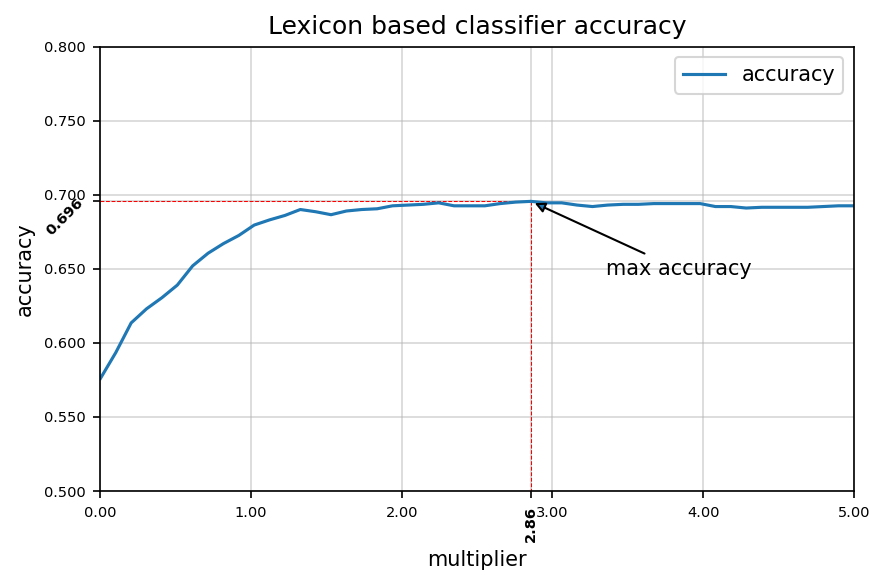

In [480]:
# YOUR CODE HERE

#lets 1st visualise how accuracy varies with multiplier
Lex_Approach.plotter(doc=reviews, lex=lexicon, better_thres=False, max_multiplier=5)

In [468]:
#now use the multiplier that gives maximum accuracy
lex_classifier_with_mag = Lex_Approach(document=reviews, sentiment_lexicon=lexicon, multiplier=2.86, use_better_threshold=False)
magnitude_accuracy = lex_classifier_with_mag.classify()
magnitude_results = lex_classifier_with_mag.results # a list of binary indicators

print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.4) Make a barplot of the two results (0.5pt)

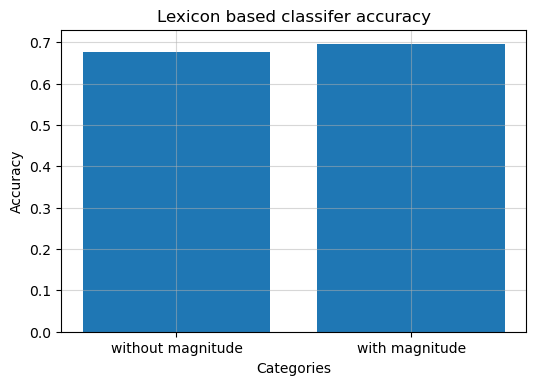

In [473]:
# YOUR CODE HERE
plt.figure(dpi=100)
height = [token_accuracy, magnitude_accuracy]
bars = ('without magnitude', 'with magnitude')
x_pos = np.arange(len(bars))
 
plt.bar(x_pos, height)
 
# Add title and axis names
plt.title('Lexicon based classifer accuracy')
plt.xlabel('Categories')
plt.ylabel('Accuracy')
 
plt.xticks(x_pos, bars)
plt.grid(alpha=0.5)
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

**Answer**  
The thresholds we used above is based on an absolute difference in positive and negative words. However it is reasonable to assume that positive words occur at a relative higher rate than negative words, for e.g. 1.05 as often (5% more). This implies that very long documents will easily pass the threshold, even if their overall sentiment is negative.

We can avoid this by computing the average score for each word over the whole doument and requiring that each review has an individual threshold which we compute as the average score times the length of each review, given as:
$$\begin{align}
\text{threshold for review}_i &= \text{average score for all words}\times\text{length of}\text{ review}_i\\
                   &= \frac{\sum_{i=1}^{N}\text{score of }\text{review}_i}{\sum_{i=1}^{N}\text{length of }\text{review}_i}\times\text{length of}\text{ review}_i,\quad \forall \,i \in \{1,2\dots N\}
\end{align}$$

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


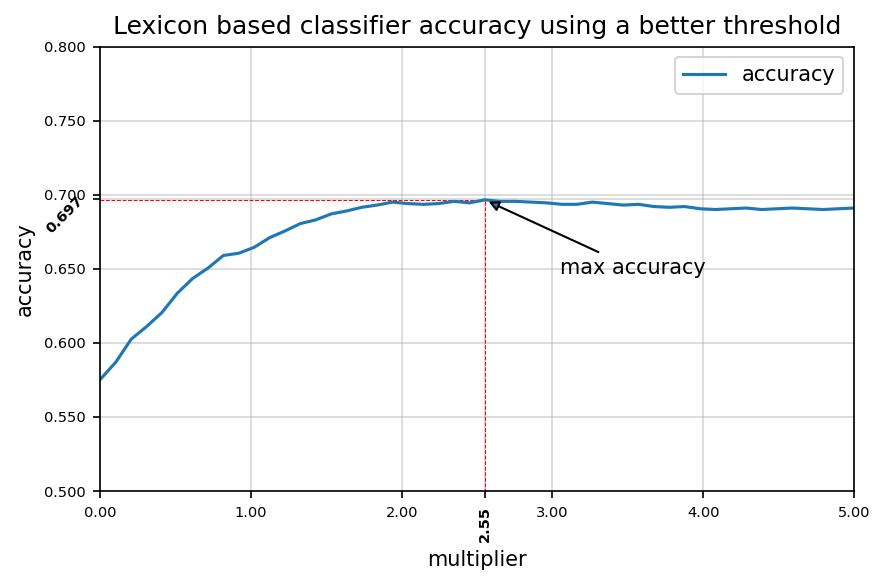

In [481]:
# YOUR CODE HERE
#lets see how accuracy changes by using the better threshold 
Lex_Approach.plotter(doc=reviews, lex=lexicon, better_thres=True, max_multiplier=5)

In [476]:
#using the multiplier that maximizes accuracy
lex_better_thresh = Lex_Approach(document=reviews, sentiment_lexicon=lexicon, multiplier=2.55, use_better_threshold=True)
better_accuracy = lex_better_thresh.classify()
print("Accuracy: %0.2f" % better_accuracy)

Accuracy: 0.70


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

*Write your answer here.*

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [706]:
# YOUR CODE HERE
class Naive_Bayes:
    def __init__(self, train, test, smoothing=0):
        assert (type(smoothing)==int and smoothing>=0), 'Smoothing takes positive integer values only!'
        self.train = train
        self.test = test
        self.smoothing = smoothing
        self.pos_bow, self.neg_bow = Counter(), Counter()
        self.results = []
        
    def bag_of_words(self):
        for review in self.train:
            senti = review['sentiment']
            for sentence in review['content']:
                for token,pos_tag in sentence:
                    if senti=='NEG': self.neg_bow[token.lower()] += 1
                    else: self.pos_bow[token.lower()] += 1
                    

    def classify(self):
        #create a bag of words
        self.bag_of_words()
        #calculate the prior probablities
        N_doc = len(self.train)
        N_pos = sum([1 for x in self.train if x['sentiment']=='POS'])
        #print('N_pos: ',N_pos,' N_doc: ',N_doc)
        prior_pos = N_pos/N_doc
        prior_neg = 1- prior_pos
        #print('prior pos prob:',prior_pos,' prior neg prob:',prior_neg)
        V = len(self.pos_bow+self.neg_bow) #total vocabulary
        total_pos = sum(self.pos_bow.values()) 
        total_neg = sum(self.neg_bow.values()) 
        #prior = np.log(0.5)               #equal number of positive and negative reviews 
        for review in self.test:
            pos_log_likelihood, neg_log_likelihood = np.log10(prior_pos), np.log10(prior_neg)
            for sentence in review['content']:
                for token,pos_tag in sentence:
                    if self.smoothing==0:
                        if self.pos_bow.get(token.lower()) != None and self.neg_bow.get(token.lower()) != None:
                            pos_log_likelihood += np.log10(self.pos_bow[token.lower()]/total_pos)
                            neg_log_likelihood += np.log10(self.neg_bow[token.lower()]/total_neg)
                        else: pass
                            #pos_log_likelihood += np.log(self.pos_bow[token.lower()]/total_pos)
                            #neg_log_likelihood += np.log(self.neg_bow[token.lower()]/total_neg)
                    else:
                        if self.pos_bow.get(token.lower()) == None and self.neg_bow.get(token.lower()) == None: pass
                        else:
                            pos_log_likelihood += np.log10((self.pos_bow[token.lower()] + self.smoothing)/(total_pos + V))
                            neg_log_likelihood += np.log10((self.neg_bow[token.lower()] + self.smoothing)/(total_neg+ V))
                            
            #print(pos_log_likelihood , neg_log_likelihood)            
            if pos_log_likelihood > neg_log_likelihood: classify = 'POS'
            else: classify = 'NEG'
                
            if classify == review['sentiment']: self.results.append(1)
            else: self.results.append(0)   
                
        return np.mean(self.results)
    
    @staticmethod
    def cross_validate(document, n_folds=10, kappa=1):
        
        all_fold_indxs = [[n for n in range(len(document)) if n % n_folds==i] for i in range(n_folds)]
        folds = [[document[idx] for idx in singl_fold_idx] for singl_fold_idx in all_fold_indxs]
        
        #print(folds)
        
        accuracy_list = []
        print('length of folds: ', len(folds))
        for i in range(n_folds):
            print('******Cross validation running for Fold {}******'.format(i+1))
            test_set = folds[i]
            train_set = [rev for j in range(n_folds) if j != i for rev in folds[j]]
            nb_classifier = Naive_Bayes(train_set, test_set, smoothing=kappa)
            acc = nb_classifier.classify()
            accuracy_list.append(acc)
            print('Accuracy:',acc)
        
        return accuracy_list
    
    '''
    @classmethod
    def from_index(cls, document, train_start_cv=0, train_end_cv=899):
        train_set, test_set = [], []
        #all_idxs = np.arange(0,1000)
        train_idxs = np.arange(train_start_cv, train_end_cv+1)
        #test_idxs = list(set(all_idxs)-set(train_idxs))
        for review in document:
            if review['cv'] in train_idxs:
                train_set.append(review)
            else:
                test_set.append(review)
                
        return cls(train_set, test_set)'''

In [700]:
train_corpus = [rev for rev in reviews if rev["cv"] < 900]
test_corpus = [rev for rev in reviews if rev["cv"] >= 900]
nb_classifier1 = Naive_Bayes(train_corpus,test_corpus)
accuracy1 = nb_classifier1.classify()
print('Accuracy : {}'.format(accuracy1))

Accuracy : 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*Write your answer here.*

In [702]:
# YOUR CODE HERE
train_corpus = [rev for rev in reviews if (rev['cv'] <= 89 or (rev['cv']<=899 and rev['sentiment']=='POS'))]
test_corpus = [rev for rev in reviews if ((900 <= rev['cv'] <= 909) or (rev['cv']>=900 and rev['sentiment']=='POS'))]
nb_classifier2 = Naive_Bayes(train_corpus, test_corpus)
accuracy2 = nb_classifier2.classify()
print('Accuracy : {}'.format(accuracy2))
#print(nb_classifier2.results)

Accuracy : 0.6


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [703]:
# YOUR CODE HERE
kappa = 1

train_corpus = [rev for rev in reviews if rev["cv"] < 900]
test_corpus = [rev for rev in reviews if rev["cv"] >= 900]
nb_classifier_smooth = Naive_Bayes(train_corpus, test_corpus, smoothing=kappa)
accuracy_smooth = nb_classifier_smooth.classify()
print('Accuracy : {}'.format(accuracy_smooth))

Accuracy : 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [708]:
# YOUR CODE HERE
N = 10
cv_accuracy_list = Naive_Bayes.cross_validate(document=reviews, n_folds=N, kappa=1)
print('Accuracy list: ', cv_accuracy_list)
cv_accuracy = np.mean(cv_accuracy_list)
print('Accuracy from 10-fold cross validation: ',np.mean(cv_accuracy_list))

length of folds:  10
******Cross validation running for Fold 1******
Accuracy: 0.79
******Cross validation running for Fold 2******
Accuracy: 0.835
******Cross validation running for Fold 3******
Accuracy: 0.805
******Cross validation running for Fold 4******
Accuracy: 0.825
******Cross validation running for Fold 5******
Accuracy: 0.78
******Cross validation running for Fold 6******
Accuracy: 0.845
******Cross validation running for Fold 7******
Accuracy: 0.83
******Cross validation running for Fold 8******
Accuracy: 0.775
******Cross validation running for Fold 9******
Accuracy: 0.83
******Cross validation running for Fold 10******
Accuracy: 0.84
Accuracy list:  [0.79, 0.835, 0.805, 0.825, 0.78, 0.845, 0.83, 0.775, 0.83, 0.84]
Accuracy from 10-fold cross validation:  0.8154999999999999


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [718]:
# YOUR CODE HERE
print('Variance of 10-fold cross validation Accuracy:', sum((np.array(cv_accuracy_list)-cv_accuracy)**2)/(N-1))

Variance of 10-fold cross validation Accuracy: 0.000669166666666665


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [ ]:
# YOUR ANSWER HERE

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# YOUR CODE HERE

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# YOUR CODE HERE


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

In [ ]:
# YOUR CODE HERE

# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE

*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE

*Write your answer here.*

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission 


In [ ]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 